In [1]:
cd SRS/

d:\Documentos\ic_tps\SRS


In [6]:
import numpy as np
from srs import SM2
from Evolutivo.evolutivo import GA
from tqdm import tqdm
from utils import fitness

n_bits = 30

# Alfa, Umbral, Phi(5), Psi(5)
var_bits = np.ones(12, dtype=int) * 30
var_lims = np.zeros(13, dtype=int)
var_lims[:-1] = np.arange(0, 12) * var_bits
var_lims[-1] = int(n_bits*12)
var_min  = np.array(
    [0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
)
var_max  = np.array(
    [100, 1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
)

interrev = 1 * 24 * 3600
nvent = 5
ancho_ventanas = np.exp( np.log(15) / nvent * np.arange(1, nvent+1))
ancho_ventanas *= (24 * 3600)

In [3]:
def DecoDecimal(v, a=var_min, b=var_max):
    vs = []
    for i in range(len(var_lims)-1):
        vs.append(v[var_lims[i]:var_lims[i+1]])

    xs = []
    xs = np.zeros(a.size)

    for (i,vi) in enumerate(vs):
        k = len(vi)
        d = sum(2**(k-np.array(range(1,k+1)))*vi)
        xs[i] = a[i] + (d*((b[i]-a[i])/((2**k)-1)))

    return xs

In [4]:
cd ..

d:\Documentos\ic_tps


In [11]:
#Cargar las matrices m_t, m_c, m_s y a lens
m_t = np.load('SRS/data/times.npy')
m_c = np.load('SRS/data/correct.npy')
m_s = np.load('SRS/data/seen.npy')
m_d = np.load('SRS/data/lexemes_dificulty.npy')
lens = np.load('SRS/data/len_schedule.npy')
lens = lens.astype(int)

#Cargamos los acums ("ASCO")
m_acum_cs = np.load('SRS/data/acum_c-res1000-sigma30.npy')
m_acum_ss = np.load('SRS/data/acum_s-res1000-sigma30.npy')

# NUMEROS MAGICOS
N = m_t.shape[0]    #Cantidad total de schedules
n = 500              #Cantidad de schedules para cada individuo

# Inicializamos la clase SRGA, que preprocesa los datos si hace falta
SM2.init_class(lens, m_t, m_c, m_s, m_d)

In [8]:
# Calculamos particiones
N_parts = 5
prct_train = .65
prct_valid = .05
len_part_train = int(N*prct_train)
len_part_valid = int(N*prct_valid)

parts_train = []
parts_test = []
parts_valid = []

idx = np.arange(0, N)

for i in range(N_parts):
    np.random.shuffle(idx)

    parts_train.append(list(idx[:len_part_train]))
    parts_valid.append(list(idx[len_part_train:len_part_train+len_part_valid]))
    parts_test.append(list(idx[len_part_train+len_part_valid:]))


In [9]:
print(f"Schedules entrenamiento: {len(parts_train[1])}")
print(f"Schedules testeo: {len(parts_test[1])}")
print(f"Schedules validacion: {len(parts_valid[1])}")
print(f"Schedules totales: {len(parts_test[1])+len(parts_train[1])+len(parts_valid[1])}")

Schedules entrenamiento: 4057
Schedules testeo: 1873
Schedules validacion: 312
Schedules totales: 6242


In [18]:
mejores_fitnesses = []
part_alfa = []
part_beta = []
part_gamma = []

#Usar particiones de entrenamiento
print("ENTRENAMIENTO....")
for j, part in tqdm(enumerate(parts_train)):
    # Definimos la funcion de fitness a utilizar (depende de algunos datos cargados)
    def f_fitness(vars):
        alfa = vars[0]
        beta = vars[1]
        gamma = vars[2]

        v_apts = np.zeros(n)
        scheds = np.random.choice(part, size=n)

        for i, s in enumerate(scheds):
            l = lens[s]
            if m_t[s,l-1] < interrev:
                continue

            sm2 = SM2(alfa, beta, gamma)
            v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=sm2)
            
        return np.average(v_apts)
        
    # Definimos parametros a usar en el evolutivo
    evolutivo_kwargs = {
                    'N'                : 20,
                    'v_var'            : var_bits,
                    'probCrossOver'    : 0.9,
                    'probMutation'     : 0.2,
                    'f_deco'           : DecoDecimal,
                    'f_fitness'        : f_fitness,
                    'maxGens'          : 10,
                    'debugLvl'         : 90,
    }

    #Evolucionamos
    ga = GA(**evolutivo_kwargs)
    ga.Evolve(elitismo=True, brecha=.4)
        
    # Guardamos datos
    bestAgent = DecoDecimal(ga.bestAgent)
    part_alfa.append(bestAgent[0])
    part_beta.append(bestAgent[1])
    part_gamma.append(bestAgent[2])
    mejores_fitnesses.append(ga.bestFitness)

    print(f"INFO PARTICION {j+1}:")
    print(f"MEDIA: {np.mean(ga.v_bestFitness)}")
    print(f"STD: {np.std(ga.v_bestFitness)}")
    print(f"MEDIANA: {np.median(ga.v_bestFitness)}")
    print(f"MAX: {np.max(ga.v_bestFitness)}")
    print(f"MIN: {np.min(ga.v_bestFitness)}\n\n")

ENTRENAMIENTO....


0it [00:00, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:07<01:11,  7.94s/it]


 20%|██        | 2/10 [00:16<01:03,  7.98s/it]


 30%|███       | 3/10 [00:24<00:56,  8.10s/it]


 40%|████      | 4/10 [00:32<00:48,  8.15s/it]


 50%|█████     | 5/10 [00:41<00:41,  8.32s/it]


 60%|██████    | 6/10 [00:50<00:34,  8.63s/it]


 70%|███████   | 7/10 [00:59<00:26,  8.81s/it]


 80%|████████  | 8/10 [01:08<00:17,  8.78s/it]


 90%|█████████ | 9/10 [01:17<00:08,  8.89s/it]


100%|██████████| 10/10 [01:26<00:00,  8.75s/it]INFO PARTICION 1:
MEDIA: 0.06090667374110331
STD: 0.002582970354877821
MEDIANA: 0.06009695351251754
MAX: 0.06572476304439165
MIN: 0.0572861032947586




1it [01:26, 86.27s/it]


  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:08<01:17,  8.63s/it]


 20%|██        | 2/10 [00:17<01:08,  8.58s/it]


 30%|███       | 3/10 [00:25<01:00,  8.64s/it]


 40%|████      | 4/10 [00:34<00:51,  8.64s/it]


 50%|█████     

In [19]:
# Imprimimos los mejores fitnesses del entrenamiento
print(f"Mejores fitnesses durante entrenamiento: {mejores_fitnesses}\n\n\n")

Mejores fitnesses durante entrenamiento: [0.06572476304439165, 0.06652789917971659, 0.06648296179283575, 0.062465552192335266, 0.06669613441599231]





In [21]:
#Particiones de testeo
part_apts = []
part_apts_mean = []
part_apts_std = []
part_best_apts = []

for j, part in tqdm(enumerate(parts_test)):

    v_apts = np.zeros(len(part))
    scheds = np.random.choice(part, size=len(part))

    for i, s in enumerate(scheds):
        l = lens[s]
        if m_t[s,l-1] < interrev:
            continue

        sm2 = SM2(part_alfa[j], part_beta[j], part_gamma[j])
        v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=sm2)
                
    part_best_apts.append(np.max(v_apts))            
    part_apts.append(v_apts)
    part_apts_mean.append(np.mean(v_apts))
    part_apts_std.append(np.std(v_apts))



0it [00:00, ?it/s]

1it [00:01,  1.34s/it]

2it [00:02,  1.34s/it]

3it [00:03,  1.32s/it]

4it [00:05,  1.32s/it]

5it [00:06,  1.29s/it]

In [158]:
mejores_fitnesses

[0.6882636894538555,
 0.6547038651574352,
 0.5435095055785201,
 0.6638405689540001,
 0.7518109288192383]

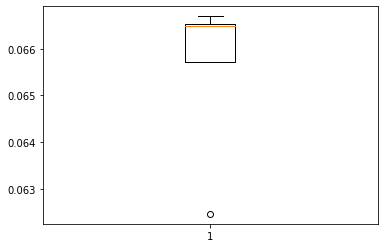

In [22]:
#Box plot de los mejores fitness del entrenamiento (de cada particion)
import matplotlib.pyplot as plt
plt.boxplot(mejores_fitnesses)
plt.show()

In [23]:
#Mejores fitness de cada particion
part_best_apts

[0.515841849336957,
 0.5314339822758113,
 0.5156727007940132,
 0.5314339822758113,
 0.5155384083427382]

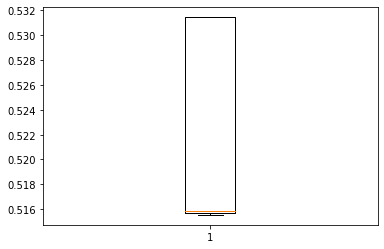

In [24]:
#Box plot de los mejores fitness del testeo (de cada particion)
plt.boxplot(part_best_apts)
plt.show()

In [26]:
#Particiones de validacion
part_apts_valid = []
part_apts_mean_valid = []
part_apts_std_valid = []
part_best_apts_valid = []

for j, part in tqdm(enumerate(parts_valid)):

    v_apts = np.zeros(len(part))
    scheds = np.random.choice(part, size=len(part))

    for i, s in enumerate(scheds):
        l = lens[s]
        if m_t[s,l-1] < interrev:
            continue
        
        sm2 = SM2(part_alfa[j], part_beta[j], part_gamma[j])
        v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=sm2)
                
    part_best_apts_valid.append(np.max(v_apts))            
    part_apts_valid.append(v_apts)
    part_apts_mean_valid.append(np.mean(v_apts))
    part_apts_std_valid.append(np.std(v_apts))



0it [00:00, ?it/s]

1it [00:00,  4.94it/s]

2it [00:00,  4.93it/s]

3it [00:00,  4.70it/s]

4it [00:00,  4.62it/s]

5it [00:01,  4.65it/s]

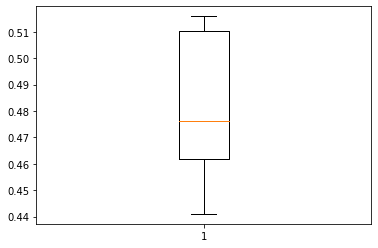

In [27]:
plt.boxplot(part_best_apts_valid)
plt.show()

In [28]:
part_best_apts_valid

[0.47620099481176115,
 0.44103082511974007,
 0.515841849336957,
 0.5101977647424512,
 0.4619164271234441]